# Implementation of Homebrew Network

In [2]:
# General imports 
import sys
import os 
sys.path.insert(1, os.path.join(os.pardir, 'src'))
from itertools import product

# Data imports
import cv2
import plotly.express as px
import numpy as np
import mlflow
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import importlib

# Homebrew imports 
import model
import layers
import activations

from utils import one_hot_encode_index
from optimizers import Adam
from activations import Softmax, ReLU
from layers import Dropout, LinearLayer, ConvolutionLayer, PoolingLayer, FlattenLayer
from loss import CategoricalCrossEntropyLoss

def nsgpmnet_reloads():
    importlib.reload(model)
    importlib.reload(layers)
    importlib.reload(activations)

nsgpmnet_reloads()

NameError: name 'importlib' is not defined

## Data loader

In [130]:
def load_set(pth):
    X = []
    y = []

    for _class in os.listdir(pth):
        for img_name in os.listdir(os.path.join(pth, _class)):
            img = cv2.imread(os.path.join(pth, _class, img_name), cv2.IMREAD_GRAYSCALE)
            X.append(img)
            y.append(_class)

    X = np.array(X)

    # Normalizing 
    X = (X - np.mean(X))/ np.mean(X)

    # Vectorizing X
    # X = X.reshape(X.shape[0], -1)

    # encoding y
    class_lbl_to_int = dict([(y, i) for i, y in enumerate(sorted(set(y)))])
    y = np.array([class_lbl_to_int[_y] for _y in y]).astype(np.uint8)
    y = one_hot_encode_index(y, len(class_lbl_to_int))

    # shuffling 
    keys = np.array(range(X.shape[0]))
    np.random.shuffle(keys)
    X = X[keys]
    y = y[keys]


    return X, y


def load_plant_data(resolution=32):
    base_dir = os.path.join(os.pardir, 'data', f'Plant_leave_diseases_{resolution}')
    train_dir = os.path.join(base_dir, 'train')
    validation_dir = os.path.join(base_dir, 'validation')

    # loading train data 
    X_train, y_train = load_set(train_dir)

    # loading validation data 
    X_validation, y_validation = load_set(validation_dir)

    return X_train, y_train, X_validation, y_validation


### Handy print function:

In [131]:
def print_info(a):
    print('shapes for inputs and outputs:')
    print(a.shape)
    print('(min, max) for inputs and outputs:')
    print(np.min(a), np.max(a))

In [173]:
X_train, y_train, X_validation, y_validation = load_plant_data()


In [174]:
print_info(X_train)

shapes for inputs and outputs:
(55327, 32, 32)
(min, max) for inputs and outputs:
-1.0 1.1170970314584487


### Reshaping data:

In [175]:
def add_channles(v):
    return np.expand_dims(v, axis=1)

X_chns_train = add_channles(X_train)
X_chns_validation = add_channles(X_validation)

### Truncation of data:

In [176]:
# Optional truncation to fewer images for integration and timing testing.
tval = 55296 # 200, 59968 (for batch_size=64), 59904 (for batch_size=128) 9984, 1024, 2048, 55296
# tval = len(X_train)

X_chns_train = X_chns_train[:tval, :, :]
X_chns_validation = X_chns_validation[:tval, :, :]

### Scaling between -1 and 1 - cnn-model

In [177]:
def scale_img(v):
    return (v - 127.5) /127.5

X_chns_train = scale_img(X_chns_train)
X_chns_validation = scale_img(X_chns_validation)

In [178]:
print_info(X_chns_train)

shapes for inputs and outputs:
(55296, 1, 32, 32)
(min, max) for inputs and outputs:
-1.007843137254902 -0.9912384546552279


### Set X to X_chns:

In [179]:
X_train = X_chns_train
X_validation = X_chns_validation

In [180]:
print_info(X_train)

shapes for inputs and outputs:
(55296, 1, 32, 32)
(min, max) for inputs and outputs:
-1.007843137254902 -0.9912384546552279


## Setting up experiments

In [181]:
# Parimiters to test

# resolutions = [32]
# leanring_rate = [0.001, 0.002]
# decay = [1e-4, 1e-3]
# dropout = [0.2, 0.9, 0.5]

resolutions = [32]
leanring_rate = [0.001]
decay = [5e-5]
dropout = [0.5]

configs = [{
    'resolution': cfg[0],
    'learning_rate': cfg[1],
    'decay': cfg[2],
    'dropout': cfg[3],
    'max_epochs': 10
    
} for cfg in product(resolutions, leanring_rate, decay, dropout)]

In [182]:
print_info(X_chns_train)
print_info(X_train)

shapes for inputs and outputs:
(55296, 1, 32, 32)
(min, max) for inputs and outputs:
-1.007843137254902 -0.9912384546552279
shapes for inputs and outputs:
(55296, 1, 32, 32)
(min, max) for inputs and outputs:
-1.007843137254902 -0.9912384546552279


In [ ]:
mlflow.set_experiment("Plant Leaf Disease")

# X_train, y_train, X_validation, y_validation = load_plant_data()

for config in configs:
    
    # initialize model 
    mdl = model.Model(Adam(learning_rate=config['learning_rate'], decay=config['decay']),
                      CategoricalCrossEntropyLoss())

    # Config early stop 
    mdl.add_early_stop(25)

    # Defining architecture 
    mdl.set_sequence([
                ConvolutionLayer(1, 32, 3),
                ReLU(),
                PoolingLayer(32, 2),
                ReLU(),
                ConvolutionLayer(32, 16, 1),
                ConvolutionLayer(16, 16, 3),
                ReLU(),
                PoolingLayer(16, 2),
                ReLU(),
                ConvolutionLayer(16, 8, 1),
                ReLU(),
                FlattenLayer(),
                LinearLayer(8 * 7 * 7, 98),
                ReLU(),
                Dropout(0.5),
                LinearLayer(98, 128),
                ReLU(),
                LinearLayer(128, 39),
                Softmax()
                    ])

    with mlflow.start_run():
        mlflow.log_param('framework', 'homebrew')
        mlflow.log_param('data_split', '90/10')
        mlflow.log_param('type', 'CNN')
        mlflow.log_params(config)
        mdl.train(X_train, y_train, epochs=config['max_epochs'], batch_size=64, log_freq=144, validation=(X_validation, y_validation))
        

### Display

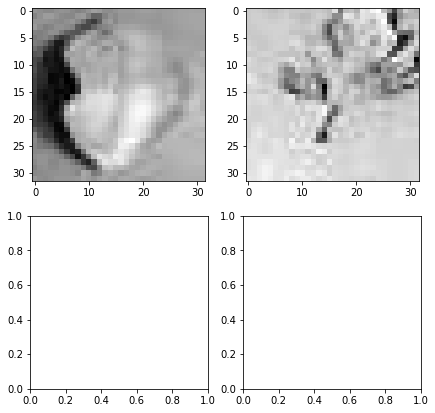

In [47]:
fig, ax = plt.subplots(figsize=(7.00, 7.00), ncols=2, nrows=2)
# fig, ax = plt.subplots()
# ax.imshow(c[0, 0, :, :], cmap=cm.gray)
ax[0, 0].imshow(X_chns_train[int(np.random.randint(0, 200)), 0, :, :], cmap=cm.gray)
ax[0, 1].imshow(X_chns_train[123, 0, :, :], cmap=cm.gray)
# ax[1, 0].imshow(pool1.dinputs[0, 0, :, :], cmap=cm.gray)
# ax[1, 1].imshow(conv1.outputs[0, 1, :, :], cmap=cm.gray)
plt.show()